<a href="https://colab.research.google.com/github/RYU-MCFLY/Aplicaciones-Financieras/blob/main/Semana_11_2_Aps_Financieras5_CrossFormer21jun23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crossformers: Transformer para series de tiempo, en que la información tenga componentes seccionales (respecto al tiempo)


Referencia: https://github.com/Thinklab-SJTU/Crossformer

In [ ]:
!git clone https://github.com/Thinklab-SJTU/Crossformer

Cloning into 'Crossformer'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 74 (delta 15), reused 70 (delta 11), pack-reused 0
Unpacking objects: 100% (74/74), 2.27 MiB | 4.55 MiB/s, done.


In [ ]:
%cd /content/Crossformer/

/content/Crossformer


In [ ]:
!ls

cross_exp     data	eval_crossformer.py  pic	requirements.txt  utils
cross_models  datasets	main_crossformer.py  readme.md	scripts


In [ ]:
# !pip install -r requirements.txt

In [ ]:
!pip install einops==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached einops-0.4.1-py3-none-any.whl (28 kB)


# Datos

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Datos de gasto energético
data = pd.read_csv('datasets/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


Mas información sobre estos datos puede ser encontrada en el siguiente [enlace](https://github.com/zhouhaoyi/ETDataset)

Las columnas de los datos representan:

- HUFL: High Useful Load
- HULL: High UseLess Load
- MUFL: Middle UseFul Load
- MULL: Middle UseLess Load
- LUFL: Low UseFul Load
- LULL: Low UseLess Load
- OT: Oil Temperature

# Archivo " main_crossformer.py" (no es necesario correr la siguiente celda)

In [ ]:
# ARCHIVO:  main_crossformer.py
import argparse
import os
import torch

from cross_exp.exp_crossformer import Exp_crossformer
from utils.tools import string_split

parser = argparse.ArgumentParser(description='CrossFormer')

parser.add_argument('--data', type=str, required=True, default='ETTh1', help='data')
parser.add_argument('--root_path', type=str, default='./datasets/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--data_split', type=str, default='0.7,0.1,0.2',help='train/val/test split, can be ratio or number')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location to store model checkpoints')

parser.add_argument('--in_len', type=int, default=96, help='input MTS length (T)')
parser.add_argument('--out_len', type=int, default=24, help='output MTS length (\tau)')
parser.add_argument('--seg_len', type=int, default=6, help='segment length (L_seg)')
parser.add_argument('--win_size', type=int, default=2, help='window size for segment merge')
parser.add_argument('--factor', type=int, default=10, help='num of routers in Cross-Dimension Stage of TSA (c)')

parser.add_argument('--data_dim', type=int, default=7, help='Number of dimensions of the MTS data (D)')
parser.add_argument('--d_model', type=int, default=256, help='dimension of hidden states (d_model)')
parser.add_argument('--d_ff', type=int, default=512, help='dimension of MLP in transformer')
parser.add_argument('--n_heads', type=int, default=4, help='num of heads')
parser.add_argument('--e_layers', type=int, default=3, help='num of encoder layers (N)')
parser.add_argument('--dropout', type=float, default=0.2, help='dropout')

parser.add_argument('--baseline', action='store_true', help='whether to use mean of past series as baseline for prediction', default=False)

parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--train_epochs', type=int, default=20, help='train epochs')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=1e-4, help='optimizer initial learning rate')
parser.add_argument('--lradj', type=str, default='type1',help='adjust learning rate')
parser.add_argument('--itr', type=int, default=1, help='experiments times')

parser.add_argument('--save_pred', action='store_true', help='whether to save the predicted future MTS', default=False)

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3',help='device ids of multile gpus')

args = parser.parse_args()

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)

data_parser = {
    'ETTh1':{'data':'ETTh1.csv', 'data_dim':7, 'split':[12*30*24, 4*30*24, 4*30*24]},
    'ETTm1':{'data':'ETTm1.csv', 'data_dim':7, 'split':[4*12*30*24, 4*4*30*24, 4*4*30*24]},
    'WTH':{'data':'WTH.csv', 'data_dim':12, 'split':[28*30*24, 10*30*24, 10*30*24]},
    'ECL':{'data':'ECL.csv', 'data_dim':321, 'split':[15*30*24, 3*30*24, 4*30*24]},
    'ILI':{'data':'national_illness.csv', 'data_dim':7, 'split':[0.7, 0.1, 0.2]},
    'Traffic':{'data':'traffic.csv', 'data_dim':862, 'split':[0.7, 0.1, 0.2]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.data_dim = data_info['data_dim']
    args.data_split = data_info['split']
else:
    args.data_split = string_split(args.data_split)

print('Args in experiment:')
print(args)

Exp = Exp_crossformer

for ii in range(args.itr):
    # setting record of experiments
    setting = 'Crossformer_{}_il{}_ol{}_sl{}_win{}_fa{}_dm{}_nh{}_el{}_itr{}'.format(args.data,
                args.in_len, args.out_len, args.seg_len, args.win_size, args.factor,
                args.d_model, args.n_heads, args.e_layers, ii)

    exp = Exp(args) # set experiments
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting, args.save_pred)

## Entrenamiento del crossformer con datos energéticos

In [ ]:
!python main_crossformer.py --data ETTh1 --in_len 168 --out_len 24 --seg_len 6 --itr 1 --train_epochs 5

Args in experiment:
Namespace(data='ETTh1', root_path='./datasets/', data_path='ETTh1.csv', data_split=[8640, 2880, 2880], checkpoints='./checkpoints/', in_len=168, out_len=24, seg_len=6, win_size=2, factor=10, data_dim=7, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=5, patience=3, learning_rate=0.0001, lradj='type1', itr=1, save_pred=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use CPU
>>>>>>>start training : Crossformer_ETTh1_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8449
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.3629456
	speed: 3.7152s/iter; left time: 4554.8658s
	iters: 200, epoch: 1 | loss: 0.3123556
	speed: 3.7380s/iter; left time: 4208.9872s
Epoch: 1 cost time: 985.327885389328
Epoch: 1, Steps: 265 | Train Loss: 0.3948671 Vali Loss: 0.5027746 Test Loss: 0.3318853
Validation loss decreased (inf --> 0.502775).  Saving model ...
	iters: 100, ep

# Archivo "eval_crossformer.py" (no es necesario correr la siguiente celda)

In [ ]:
# ARCHIVO:  eval_crossformer.py
import argparse
import os
import torch
import pickle

from cross_exp.exp_crossformer import Exp_crossformer
from utils.tools import load_args, string_split

parser = argparse.ArgumentParser(description='CrossFormer')

parser.add_argument('--checkpoint_root', type=str, default='./checkpoints', help='location of the trained model')
parser.add_argument('--setting_name', type=str, default='Crossformer_ETTh1_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0', help='name of the experiment')

parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')

parser.add_argument('--different_split', action='store_true', help='use data split different from training process', default=False)
parser.add_argument('--data_split', type=str, default='0.7,0.1,0.2', help='data split of train, vali, test')

parser.add_argument('--inverse', action='store_true', help='inverse output data into the original scale', default=False)
parser.add_argument('--save_pred', action='store_true', help='whether to save the predicted future MTS', default=False)

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')

args = parser.parse_args()

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
args.use_multi_gpu = False

args.checkpoint_dir = os.path.join(args.checkpoint_root, args.setting_name)
hyper_parameters = load_args(os.path.join(args.checkpoint_dir, 'args.json'))

#load the pre-trained model
args.data_dim = hyper_parameters['data_dim']; args.in_len = hyper_parameters['in_len']; args.out_len = hyper_parameters['out_len'];
args.seg_len = hyper_parameters['seg_len']; args.win_size = hyper_parameters['win_size']; args.factor = hyper_parameters['factor'];
args.d_model = hyper_parameters['d_model']; args.d_ff = hyper_parameters['d_ff']; args.n_heads = hyper_parameters['n_heads'];
args.e_layers = hyper_parameters['e_layers']; args.dropout = hyper_parameters['dropout']; args.baseline = hyper_parameters['baseline'];
exp = Exp_crossformer(args)
model_dict = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pth'), map_location='cpu')
exp.model.load_state_dict(model_dict)

#load the data
args.scale_statistic = pickle.load(open(os.path.join(args.checkpoint_dir, 'scale_statistic.pkl'), 'rb'))
args.root_path = hyper_parameters['root_path']; args.data_path = hyper_parameters['data_path'];
if args.different_split:
    data_split = string_split(args.data_split)
    args.data_split = data_split
else:
    args.data_split = hyper_parameters['data_split']

mae, mse, rmse, mape, mspe = exp.eval(args.setting_name, args.save_pred, args.inverse)

folder_path = './results/' + args.setting_name +'/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
log_file = open(folder_path+'metric.log', 'w')
log_file.write('Data Path: {}\n'.format(os.path.join(args.root_path, args.data_path)))
log_file.write('Data Split: {}\n'.format(args.data_split))
log_file.write('Input Length:{}   Output Length:{}\n'.format(args.in_len, args.out_len))
log_file.write('Inverse to original scale: {}\n\n'.format(args.inverse))
log_file.write('MAE:{}\nMSE:{}\nRMSE:{}\nMAPE:{}\nMSPE:{}\n'.format(mae, mse, rmse, mape, mspe))
log_file.close()



## Evaluación del crossformer para datos energéticos

In [ ]:
!python eval_crossformer.py --checkpoint_root ./checkpoints --setting_name Crossformer_ETTh1_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0 --save_pred

Use CPU
mse:0.29987940192222595, mae:0.35912710428237915


In [ ]:
aaa = np.load('/content/Crossformer/results/Crossformer_ETTh1_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0/pred.npy')

In [ ]:
aaa[0][0][:,0] # de 24 x 7, dimensión de los datos de entrada

array([[ 0.3450942 ,  0.5370596 ,  0.5442071 ,  0.64566016, -0.24150851,
         0.371054  , -1.0810331 ],
       [ 0.430861  ,  0.76684034,  0.61297965,  0.79970473, -0.19564533,
         0.46197665, -1.0745885 ],
       [ 0.23844552,  0.5856557 ,  0.43291944,  0.61845124, -0.39271137,
         0.47589853, -1.1143143 ],
       [ 0.16875565,  0.471321  ,  0.39063758,  0.3897835 , -0.4809264 ,
         0.41798633, -1.0809681 ],
       [ 0.3168033 ,  0.4185969 ,  0.5040122 ,  0.27952838, -0.23551649,
         0.43420127, -1.1073275 ],
       [ 0.3901978 ,  0.4017012 ,  0.5295799 ,  0.3332271 ,  0.05901045,
         0.44380873, -1.1288794 ],
       [ 0.4157943 ,  0.3429999 ,  0.4361989 ,  0.27716795,  0.58986235,
         0.4750986 , -1.1174113 ],
       [ 0.2116422 ,  0.44530982,  0.20909429,  0.39127585,  0.6332527 ,
         0.59296787, -1.0319574 ],
       [-0.4205979 ,  0.30370104, -0.41266358,  0.27360332,  0.26581115,
         0.55360454, -1.1007845 ],
       [-1.1069531 ,  0.2080

In [ ]:
bbb = np.load('/content/Crossformer/results/Crossformer_ETTh1_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0/true.npy')

In [ ]:
aaa[0][:,0]
bbb[0][:,0]

array([ 0.351341  ,  0.06335341,  0.14386615,  0.02877421,  0.08623421,
        0.08623421,  0.29370925, -0.10954233, -1.5154175 , -2.8289094 ,
       -3.4511623 , -3.647111  , -3.589479  , -3.1862276 , -3.3706496 ,
       -2.6100802 , -1.3079425 , -0.06343684, -0.0058049 ,  0.05182712,
        0.01724792, -0.1902271 ,  0.12081341,  0.5703425 ], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

# Comparativo entre valores reales y predicciones, para datos de test

OJO: Los datos están estandarizados, por lo que debemos regresarlos a su tamaño original si quisieramos no solo ver que tanto nos acercamos a los valores si no los valores reales tal cual.

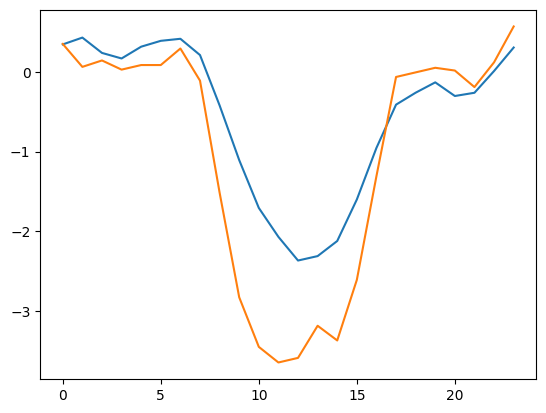

In [ ]:
plt.plot(aaa[0][:,0], label="Valor predicho")
plt.plot(bbb[0][:,0], label="Valor real")

# Otros datos

In [ ]:
import yfinance as yf

In [ ]:
datos = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "PFE AAPL IBM MSFT XOM",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "2y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1h",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
datos

[*********************100%***********************]  5 of 5 completed


,AAPL,IBM,MSFT,PFE,XOM
Datetime,,,,,
2021-06-22 09:30:00-04:00,132.119904,139.818359,264.214996,39.410000,63.236801
2021-06-22 10:30:00-04:00,132.615005,139.978210,264.433014,39.540001,63.669998
2021-06-22 11:30:00-04:00,132.917297,139.426392,264.725006,39.687199,63.570000
2021-06-22 12:30:00-04:00,133.320099,139.713196,264.549286,39.662998,63.645000
2021-06-22 13:30:00-04:00,133.335602,139.588913,264.522003,39.505001,63.770000
...,...,...,...,...,...
2023-06-21 11:30:00-04:00,184.065002,134.046005,333.690002,39.160000,104.489998
2023-06-21 12:30:00-04:00,184.130005,133.970001,333.669891,39.100101,104.349998
2023-06-21 13:30:00-04:00,185.100006,133.679993,335.209991,39.148201,104.269997


In [ ]:
datos.reset_index(inplace=True)
datos.rename(columns={'Datetime': 'date'}, inplace=True)
datos

,date,AAPL,IBM,MSFT,PFE,XOM
0,2021-06-22 09:30:00-04:00,132.119904,139.818359,264.214996,39.410000,63.236801
1,2021-06-22 10:30:00-04:00,132.615005,139.978210,264.433014,39.540001,63.669998
2,2021-06-22 11:30:00-04:00,132.917297,139.426392,264.725006,39.687199,63.570000
3,2021-06-22 12:30:00-04:00,133.320099,139.713196,264.549286,39.662998,63.645000
4,2021-06-22 13:30:00-04:00,133.335602,139.588913,264.522003,39.505001,63.770000
...,...,...,...,...,...,...
3508,2023-06-21 11:30:00-04:00,184.065002,134.046005,333.690002,39.160000,104.489998
3509,2023-06-21 12:30:00-04:00,184.130005,133.970001,333.669891,39.100101,104.349998
3510,2023-06-21 13:30:00-04:00,185.100006,133.679993,335.209991,39.148201,104.269997
3511,2023-06-21 14:30:00-04:00,184.505005,133.800003,334.170013,39.052799,104.153198


In [ ]:
datos.to_csv('datasets/yf_datos.csv', encoding='utf-8-sig', index=False)
datos.to_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana11/yf_datos.csv', encoding='utf-8-sig', index=False)

In [ ]:
!python main_crossformer.py --data yf_datos --in_len 168 --out_len 24 --seg_len 6 --itr 1 --data_path yf_datos.csv --data_dim 5 --train_epochs 5

Args in experiment:
Namespace(data='yf_datos', root_path='./datasets/', data_path='yf_datos.csv', data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=168, out_len=24, seg_len=6, win_size=2, factor=10, data_dim=5, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=2, patience=3, learning_rate=0.0001, lradj='type1', itr=1, save_pred=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use CPU
>>>>>>>start training : Crossformer_yf_datos_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 2268
val 329
test 679
Epoch: 1 cost time: 205.83442521095276
Epoch: 1, Steps: 71 | Train Loss: 0.4131781 Vali Loss: 0.2146662 Test Loss: 0.0939211
Validation loss decreased (inf --> 0.214666).  Saving model ...
Epoch: 2 cost time: 204.26034426689148
Epoch: 2, Steps: 71 | Train Loss: 0.1611887 Vali Loss: 0.1733536 Test Loss: 0.0850371
Validation loss decreased (0.214666 --> 0.173354).  S

In [ ]:
!python eval_crossformer.py --checkpoint_root ./checkpoints --setting_name Crossformer_yf_datos_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0 --save_pred

Use CPU
mse:0.08400412648916245, mae:0.22389203310012817


In [ ]:
aaa = np.load('/content/Crossformer/results/Crossformer_yf_datos_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0/pred.npy')

In [ ]:
bbb = np.load('/content/Crossformer/results/Crossformer_yf_datos_il168_ol24_sl6_win2_fa10_dm256_nh4_el3_itr0/true.npy')

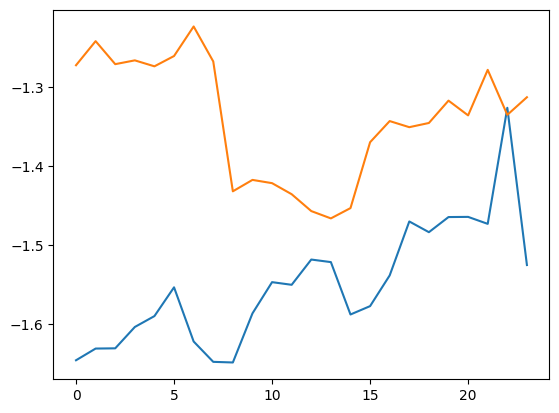

In [ ]:
token = 2
plt.plot(aaa[1][:,token], label="Valor predicho")
plt.plot(bbb[1][:,token], label="Valor real")

In [ ]:
token = 3
plt.plot(aaa[1][:,token])
plt.plot(bbb[1][:,token])

In [ ]:
token = 4
plt.plot(aaa[1][:,token])
plt.plot(bbb[1][:,token])